In [137]:
import os
import numpy as np

from src.data_reader import DataSource
import csv

import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score, top_k_accuracy_score

import torch
from src.learning.nn import SimpleNN, predict

### Predict on test set

In [219]:
# READ DATA


dataAlphaTest = np.load('./data/savedAlpha/AlphaDescriptors_test_aug.npy')
dataSectorsTest = np.load('./data/savedSectors/test_set_aug.npy')

labels = np.load('./data/labels/labels_train_aug.npy')

test = np.concatenate( [dataSectorsTest ] , axis = 1 )

# PREDICT ON TEST SET

print('Prediction on test set \n')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = test.shape[1]
c = np.unique(labels).shape[0]
trained_model_path = './data/trained_models/best_model.pth'

model = SimpleNN(m, c)
model.load_state_dict(torch.load(trained_model_path))
model.to(device)
model.eval()

X_predict = torch.tensor(test, dtype=torch.float32).to(device)
output = model( X_predict )

y_pred = torch.argmax(output, dim=1)
y_pred = y_pred.cpu().numpy()

# FINAL CLASSIFICATION

print('Majority voting and class frequencies')

# y_pred has 60 predictions for each original protein. We now compute the majority vote
# and break ties by a-priori class frequency

# a-priori class frequency
uni_classes , class_counts = np.unique(labels[::60], return_counts=True)
a_priori_freq = {}
for i,c in enumerate(uni_classes):
    a_priori_freq[c] = class_counts[i]

# majority vote
bl_pred = y_pred.reshape(-1,60) # reshape in blocks of 60, each is one protein
uni_counts = [np.unique(block, return_counts=True) for block in bl_pred]

sorted_classes = []

for protein in uni_counts:
    classes = protein[0]
    counts = protein[1]

    order = np.argsort(counts)[::-1]

    classes = classes[order]
    counts = counts[order]

    sorted_classes.append( [ classes, counts ] )

sorted_classes = [ [x[0] , [y for y in x[1]]] for x in sorted_classes ]
sorted_classes = [ [ x[0].tolist(), x[1]] for x in sorted_classes]

# put the two together
majority_voting = []
count_ties = 0

for classes, counts in sorted_classes:

    max_freq = np.max(counts) # the most frequent classes have this number of instances

    tied_classes = [cls for cls, cts in zip(classes, counts) if cts == max_freq] # find which have that frequency

    if len(tied_classes)==1: # if there are no ties
        majority_voting.append(tied_classes[0]) # it' simply that class

    else: # if there is more than one class with the same prediction confidence
        top_class = max( tied_classes, key = lambda n : a_priori_freq[n] ) # choose based on the a-priori frequency
        majority_voting.append(top_class)
        count_ties += 1

majority_voting = np.array(majority_voting).reshape((len(majority_voting)),)

Prediction on test set 

Majority voting and class frequencies


In [220]:
np.save('./data/savedPredictions/SectorsWeightedCE.npy', majority_voting)

print('There were ', count_ties, ' ties broken by a priori frequency')

There were  5  ties broken by a priori frequency


## Reload Prediction

In [221]:
predS = np.load('./data/savedPredictions/PredSectorsWeightedCESmoothed.npy')
predW = np.load('./data/savedPredictions/SectorsWeightedCE.npy')

In [222]:
pred.shape

(2321,)

In [223]:
Ground_Truth = {}
with open('./data/data/test_set_ground_truth.csv', 'r') as csvfile:
    truths = csv.reader(csvfile)

    next(truths, None) # skip first row, it's a header

    for t in truths:
        Ground_Truth[t[0]] = int(t[1])

ground_truths = []
test_set = DataSource( './data/data/test_set/', base_path='./data/data/test_set')

for f in test_set:

    filename = os.path.basename(f)
    filename, _ = os.path.splitext(filename)
    
    ground_truths.append(Ground_Truth[filename])

ground_truths = np.array(ground_truths).reshape((len(ground_truths),))

uni_classes , class_counts = np.unique(ground_truths, return_counts=True)
a_priori_freq = {}
for i,c in enumerate(uni_classes):
    a_priori_freq[c] = class_counts[i]

In [224]:
len(Ground_Truth.keys())

2321

In [225]:
ground_truths.shape

(2321,)

In [226]:
ground_truths

array([88, 10,  8, ..., 51, 90, 14])

In [227]:
accuracy_score(ground_truths, predW)

0.6574752261956054

In [228]:
accuracy_score(ground_truths, predS)

0.8082722964239551

In [229]:
balanced_accuracy_score(ground_truths, predW)

/home/marco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.7298763818717855

In [230]:
balanced_accuracy_score(ground_truths, predS)

/home/marco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.7303938711945018

### Top-k accuracy

In [231]:
scores = np.zeros((pred.shape[0], 97))

for i, sample in enumerate(uni_counts):
    for j,c in enumerate(sample[0]):
        scores[i,c] = sample[1][j] / 60

In [237]:
top_k_accuracy_score(ground_truths, scores, k=2, labels=np.arange(97))

0.7113313227057303

## Per-class f1 accuracy
Testing per-class accuracy when using weighted CE instead of unweighted

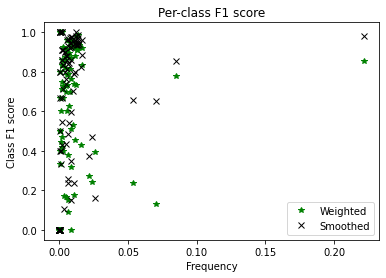

In [241]:
f1Smooth = f1_score(ground_truths, predS, average=None, labels=list(range(97)), zero_division=0.0 )

f1 = f1_score(ground_truths, predW, average=None, labels=list(range(97)), zero_division=0.0 )

freqs = np.array([ a_priori_freq[i] if i in a_priori_freq.keys() else 0.0 for i in range(97) ])

freqs = freqs / np.sum(freqs)

data = np.stack([freqs, f1]).T
dataSmooth = np.stack([freqs, f1Smooth]).T


plt.plot( data[:,0] , data[:,1], '*g' , label='Weighted');
plt.plot( dataSmooth[:,0] , dataSmooth[:,1], 'xk', label='Smoothed' );
plt.xlabel('Frequency');
plt.ylabel('Class F1 score');
plt.title('Per-class F1 score');
plt.legend()

In [242]:
np.mean(data[ data[:,0] < .045 ][:,1])

0.5995054423664258

In [243]:
np.mean(dataSmooth[ dataSmooth[:,0] < .045 ][:,1])

0.6425603215818568

### Class frequency

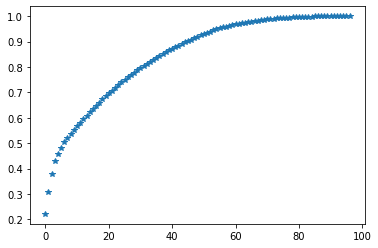

In [244]:
plt.plot(np.cumsum(np.sort(freqs)[::-1] ), '*')

In [245]:
# Indices of those classes with at least 0.001 frequency
keep_classes = np.arange(97)[freqs>=.001]
keep_classes

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 24, 25, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41,
       43, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 64,
       66, 67, 69, 70, 71, 74, 75, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90,
       91, 92, 93, 94, 96])

## Score on large classes

In [246]:
mask = np.isin(ground_truths,keep_classes) & np.isin(predW, keep_classes)
print("Raw",accuracy_score(ground_truths, predW))
print("Raw balanced",balanced_accuracy_score(ground_truths, predW))
print("Large classes",accuracy_score(ground_truths[mask], predW[mask]))
print("Large classes balanced", balanced_accuracy_score(ground_truths[mask], predW[mask]))

Raw 0.6574752261956054
Raw balanced 0.7298763818717855
Large classes 0.6659330985915493
Large classes balanced 0.7703823514384358


/home/marco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [248]:
mask = np.isin(ground_truths,keep_classes) & np.isin(predS, keep_classes)
print("Raw",accuracy_score(ground_truths, predS))
print("Raw balanced",balanced_accuracy_score(ground_truths, predS))
print("Large classes",accuracy_score(ground_truths[mask], predS[mask]))
print("Large classes balanced", balanced_accuracy_score(ground_truths[mask], predS[mask]))


Raw 0.8082722964239551
Raw balanced 0.7303938711945018
Large classes 0.8153980752405949
Large classes balanced 0.7791024414247272


/home/marco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [54]:
with open('./data/data/test_set_ground_truth.csv', 'r') as csvfile:

    truths = csv.reader(csvfile)
    next(truths)
    truths = [t for t in truths]

In [56]:
truths = [[ int(t[0]) , int(t[1]) ]for t in truths]

In [57]:
truths

[[0, 88],
 [1, 10],
 [2, 8],
 [3, 54],
 [4, 41],
 [5, 14],
 [6, 69],
 [7, 8],
 [8, 8],
 [9, 33],
 [10, 8],
 [11, 8],
 [12, 8],
 [13, 8],
 [14, 93],
 [15, 71],
 [16, 21],
 [17, 56],
 [18, 56],
 [19, 32],
 [20, 8],
 [21, 15],
 [22, 14],
 [23, 14],
 [24, 40],
 [25, 14],
 [26, 8],
 [27, 8],
 [28, 54],
 [29, 14],
 [30, 8],
 [31, 91],
 [32, 14],
 [33, 51],
 [34, 90],
 [35, 8],
 [36, 83],
 [37, 86],
 [38, 8],
 [39, 61],
 [40, 92],
 [41, 56],
 [42, 62],
 [43, 8],
 [44, 25],
 [45, 0],
 [46, 8],
 [47, 56],
 [48, 49],
 [49, 56],
 [50, 9],
 [51, 86],
 [52, 41],
 [53, 8],
 [54, 8],
 [55, 60],
 [56, 8],
 [57, 56],
 [58, 9],
 [59, 8],
 [60, 15],
 [61, 54],
 [62, 92],
 [63, 11],
 [64, 54],
 [65, 25],
 [66, 14],
 [67, 88],
 [68, 61],
 [69, 86],
 [70, 79],
 [71, 56],
 [72, 60],
 [73, 8],
 [74, 81],
 [75, 25],
 [76, 8],
 [77, 96],
 [78, 75],
 [79, 75],
 [80, 90],
 [81, 61],
 [82, 90],
 [83, 8],
 [84, 16],
 [85, 8],
 [86, 14],
 [87, 54],
 [88, 69],
 [89, 8],
 [90, 64],
 [91, 8],
 [92, 87],
 [93, 8],
 [94,

In [59]:
tr = np.array([t[1] for t in truths], dtype=int)

In [76]:
uni_true = set(np.unique(tr))

In [77]:
uni_pred = set(np.unique(pred))

In [82]:
uni_true - uni_pred

{12, 23, 27, 65, 89}

In [83]:
uni_pred - uni_true

{72, 77}

In [87]:
len(a_priori_freq.keys())

88

In [99]:
a_priori_freq[12]

2

In [98]:
tr[tr==12].shape

(2,)

In [316]:
labels = np.load('./data/labels/labels_train_aug.npy')

In [105]:
uni_labels = set(np.unique(labels))

In [133]:
all_classes = np.concatenate([labels[::60], ground_truths], axis=0)

uni_classes , class_counts = np.unique(all_classes, return_counts=True)
A_priori_freq = {}
for i,c in enumerate(uni_classes):
    A_priori_freq[c] = class_counts[i]/all_classes.shape[0]

In [134]:
A_priori_freq

{0: 0.01098140942498919,
 1: 0.0003458711629917856,
 2: 0.0018158236057068742,
 3: 0.002248162559446606,
 4: 0.0016428880242109814,
 5: 0.013748378728923476,
 6: 0.002680501513186338,
 7: 0.008127972330306961,
 8: 0.22204928664072632,
 9: 0.00717682663207955,
 10: 0.0015564202334630351,
 11: 0.004669260700389105,
 12: 0.0010376134889753567,
 13: 0.0023346303501945525,
 14: 0.05309122351923908,
 15: 0.00959792477302205,
 16: 0.016688283614353653,
 17: 0.012537829658452227,
 18: 0.008214440121054907,
 19: 0.004582792909641159,
 20: 0.0007782101167315176,
 21: 0.008041504539559013,
 22: 0.0062256809338521405,
 23: 0.0010376134889753567,
 24: 0.001124081279723303,
 25: 0.015477734543882404,
 26: 0.0001729355814958928,
 27: 0.0003458711629917856,
 28: 0.001988759187202767,
 29: 0.0014699524427150886,
 30: 0.0003458711629917856,
 31: 0.003545179420665802,
 32: 0.010030263726761782,
 33: 0.01366191093817553,
 34: 0.007955036748811067,
 35: 0.0025075659316904455,
 36: 0.0008646779074794639,
 3

In [223]:
prediction = csv.reader(open('../SHREC25/OldData/results/classification135/Classification135.csv', 'r'))

In [224]:
next(prediction)

['Protein', 'Class']

In [225]:
prediction = [p for p in prediction]

In [226]:
prediction

[['0', '39'],
 ['1', '10'],
 ['2', '8'],
 ['3', '90'],
 ['4', '14'],
 ['5', '56'],
 ['6', '14'],
 ['7', '8'],
 ['8', '81'],
 ['9', '90'],
 ['10', '91'],
 ['11', '8'],
 ['12', '79'],
 ['13', '8'],
 ['14', '19'],
 ['15', '90'],
 ['16', '90'],
 ['17', '40'],
 ['18', '70'],
 ['19', '61'],
 ['20', '70'],
 ['21', '56'],
 ['22', '45'],
 ['23', '8'],
 ['24', '56'],
 ['25', '14'],
 ['26', '25'],
 ['27', '16'],
 ['28', '37'],
 ['29', '8'],
 ['30', '8'],
 ['31', '14'],
 ['32', '87'],
 ['33', '14'],
 ['34', '92'],
 ['35', '56'],
 ['36', '83'],
 ['37', '14'],
 ['38', '90'],
 ['39', '8'],
 ['40', '8'],
 ['41', '15'],
 ['42', '8'],
 ['43', '56'],
 ['44', '33'],
 ['45', '62'],
 ['46', '7'],
 ['47', '79'],
 ['48', '21'],
 ['49', '8'],
 ['50', '84'],
 ['51', '22'],
 ['52', '86'],
 ['53', '22'],
 ['54', '9'],
 ['55', '90'],
 ['56', '86'],
 ['57', '49'],
 ['58', '55'],
 ['59', '56'],
 ['60', '41'],
 ['61', '70'],
 ['62', '49'],
 ['63', '90'],
 ['64', '87'],
 ['65', '60'],
 ['66', '56'],
 ['67', '7'],
 ['6

In [220]:
prediction = [ [int(p[0]) , int(p[1])] for p in prediction ]

In [221]:
Old_pred = {}
for p in prediction:
    Old_pred[str(p[0])] = p[1]

In [222]:
Old_pred

{'0': 39,
 '1': 10,
 '2': 8,
 '3': 90,
 '4': 14,
 '5': 56,
 '6': 14,
 '7': 8,
 '8': 81,
 '9': 90,
 '10': 91,
 '11': 8,
 '12': 79,
 '13': 8,
 '14': 19,
 '15': 90,
 '16': 90,
 '17': 40,
 '18': 70,
 '19': 61,
 '20': 70,
 '21': 56,
 '22': 45,
 '23': 8,
 '24': 56,
 '25': 14,
 '26': 25,
 '27': 16,
 '28': 37,
 '29': 8,
 '30': 8,
 '31': 14,
 '32': 87,
 '33': 14,
 '34': 92,
 '35': 56,
 '36': 83,
 '37': 14,
 '38': 90,
 '39': 8,
 '40': 8,
 '41': 15,
 '42': 8,
 '43': 56,
 '44': 33,
 '45': 62,
 '46': 7,
 '47': 79,
 '48': 21,
 '49': 8,
 '50': 84,
 '51': 22,
 '52': 86,
 '53': 22,
 '54': 9,
 '55': 90,
 '56': 86,
 '57': 49,
 '58': 55,
 '59': 56,
 '60': 41,
 '61': 70,
 '62': 49,
 '63': 90,
 '64': 87,
 '65': 60,
 '66': 56,
 '67': 7,
 '68': 90,
 '69': 15,
 '70': 8,
 '71': 87,
 '72': 14,
 '73': 13,
 '74': 91,
 '75': 34,
 '76': 8,
 '77': 8,
 '78': 88,
 '79': 86,
 '80': 8,
 '81': 8,
 '82': 91,
 '83': 56,
 '84': 96,
 '85': 8,
 '86': 15,
 '87': 8,
 '88': 8,
 '89': 90,
 '90': 90,
 '91': 8,
 '92': 8,
 '93': 90,


In [230]:
old_pred[:15]

array([39, 10, 91, 86, 16, 47, 14, 90, 71, 21, 84, 64, 92, 92, 91])

In [231]:
ground_truths[:15]

array([88, 10,  8, 61, 14, 93, 14,  8, 81, 90, 91,  8, 70,  8, 88])

In [211]:
Ground_Truth

{'0': 88,
 '1': 10,
 '2': 8,
 '3': 54,
 '4': 41,
 '5': 14,
 '6': 69,
 '7': 8,
 '8': 8,
 '9': 33,
 '10': 8,
 '11': 8,
 '12': 8,
 '13': 8,
 '14': 93,
 '15': 71,
 '16': 21,
 '17': 56,
 '18': 56,
 '19': 32,
 '20': 8,
 '21': 15,
 '22': 14,
 '23': 14,
 '24': 40,
 '25': 14,
 '26': 8,
 '27': 8,
 '28': 54,
 '29': 14,
 '30': 8,
 '31': 91,
 '32': 14,
 '33': 51,
 '34': 90,
 '35': 8,
 '36': 83,
 '37': 86,
 '38': 8,
 '39': 61,
 '40': 92,
 '41': 56,
 '42': 62,
 '43': 8,
 '44': 25,
 '45': 0,
 '46': 8,
 '47': 56,
 '48': 49,
 '49': 56,
 '50': 9,
 '51': 86,
 '52': 41,
 '53': 8,
 '54': 8,
 '55': 60,
 '56': 8,
 '57': 56,
 '58': 9,
 '59': 8,
 '60': 15,
 '61': 54,
 '62': 92,
 '63': 11,
 '64': 54,
 '65': 25,
 '66': 14,
 '67': 88,
 '68': 61,
 '69': 86,
 '70': 79,
 '71': 56,
 '72': 60,
 '73': 8,
 '74': 81,
 '75': 25,
 '76': 8,
 '77': 96,
 '78': 75,
 '79': 75,
 '80': 90,
 '81': 61,
 '82': 90,
 '83': 8,
 '84': 16,
 '85': 8,
 '86': 14,
 '87': 54,
 '88': 69,
 '89': 8,
 '90': 64,
 '91': 8,
 '92': 87,
 '93': 8,
 '94'

In [228]:
old_pred = []
test_set = DataSource( './data/data/test_set/', base_path='./data/data/test_set')

for f in test_set:

    filename = os.path.basename(f)
    filename, _ = os.path.splitext(filename)

    print(filename)
    
    old_pred.append(Old_pred[filename])

old_pred = np.array(old_pred).reshape((len(old_pred),))

0
1
10
100
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
101
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
102
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
103
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
104
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
105
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
106
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
107
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
108
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
109
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
11
110
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
111
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
112
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
113
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
114
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
115
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
116
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
117
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
118
1180
1181
1182

In [227]:
old_pred[:15]

array([39, 10, 91, 86, 16, 47, 14, 90, 71, 21, 84, 64, 92, 92, 91])

In [215]:
ground_truths[:15]

array([88, 10,  8, 61, 14, 93, 14,  8, 81, 90, 91,  8, 70,  8, 88])

In [255]:
accuracy_score(ground_truths, old_pred[permutation])

0.8448944420508402

In [258]:
report = classification_report(ground_truths, old_pred[permutation], zero_division=0)

In [259]:
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       1.00      1.00      1.00         1
           2       1.00      0.75      0.86         4
           3       1.00      0.80      0.89         5
           4       0.80      1.00      0.89         4
           5       0.97      1.00      0.98        32
           6       1.00      0.33      0.50         6
           7       0.78      0.74      0.76        19
           8       0.98      1.00      0.99       514
           9       0.85      1.00      0.92        17
          10       1.00      0.75      0.86         4
          11       0.71      0.91      0.80        11
          12       1.00      0.50      0.67         2
          13       0.71      1.00      0.83         5
          14       0.68      0.82      0.75       125
          15       1.00      1.00      1.00        22
          16       0.92      0.85      0.88        39
          17       0.93    

In [232]:
import pandas as pd

In [248]:
df = pd.read_csv('../SHREC25/CombinedMethod/Permutation.csv', header=None)

In [250]:
permutation = df.values

In [251]:
permutation = permutation[:,0]

In [252]:
permutation.shape

(2321,)

In [254]:
accuracy_score(ground_truths, old_pred[permutation])

0.8448944420508402

In [260]:
accuracy_score(ground_truths, pred)

0.7837139164153382

In [261]:
report = classification_report(ground_truths, pred, zero_division=0)

In [262]:
print(report)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.50      1.00      0.67         1
           2       1.00      0.75      0.86         4
           3       0.80      0.80      0.80         5
           4       0.20      0.25      0.22         4
           5       0.94      0.97      0.95        32
           6       0.50      0.17      0.25         6
           7       1.00      0.79      0.88        19
           8       0.97      0.99      0.98       514
           9       0.84      0.94      0.89        17
          10       1.00      0.50      0.67         4
          11       0.64      0.64      0.64        11
          12       0.00      0.00      0.00         2
          13       0.56      1.00      0.71         5
          14       0.64      0.81      0.72       125
          15       0.79      0.68      0.73        22
          16       0.87      0.85      0.86        39
          17       0.92    

In [282]:
trset = pd.read_csv('./data/data/train_set.csv').values

In [285]:
trset = trset.tolist()

In [287]:
trset = list(sorted( trset , key=lambda x: x[0]))

In [288]:
trset

[['105m_1:A:A_model1', 19],
 ['107m_1:A:A_model1', 88],
 ['110m_1:A:A_model1', 39],
 ['112m_1:A:A_model1', 39],
 ['1a6g_1:A:A_model1', 39],
 ['1a6m_1:A:A_model1', 19],
 ['1a6n_1:A:A_model1', 19],
 ['1abs_1:A:A_model1', 39],
 ['1agr_1:A:A_model1', 94],
 ['1agr_1:B:D_model1', 94],
 ['1as0_1:A:A_model1', 94],
 ['1as3_1:A:A_model1', 94],
 ['1aum_1:A:A_model1', 1],
 ['1azi_1:A:A_model1', 15],
 ['1bgy_8:S:T_model1', 46],
 ['1bje_1:A:A_model1', 88],
 ['1bmf_3:G:G_model1', 38],
 ['1bvd_1:A:A_model1', 19],
 ['1bzr_1:A:A_model1', 19],
 ['1c0u_1:A:A_model1', 22],
 ['1c1b_1:A:A_model1', 22],
 ['1c1c_1:A:A_model1', 22],
 ['1c3b_1:A:A_model1', 54],
 ['1cip_1:A:A_model1', 94],
 ['1cow_3:G:G_model1', 38],
 ['1do7_1:A:A_model1', 88],
 ['1dtt_1:A:A_model1', 22],
 ['1dwt_1:A:A_model1', 15],
 ['1e1q_3:G:G_model1', 38],
 ['1e1r_3:G:G_model1', 38],
 ['1e6j_3:C:P_model1', 8],
 ['1e79_3:G:G_model1', 38],
 ['1efr_3:G:G_model1', 38],
 ['1eo8_2:B:B_model1', 53],
 ['1ep4_1:A:A_model1', 22],
 ['1eqy_2:B:A_model1',

In [309]:
cond_lab[:20]

array([19, 88, 39, 39, 39, 19, 19, 39, 94, 94, 94, 94,  1, 15, 46, 88, 38,
       19, 19, 22])

In [315]:
source = DataSource('./data/data/train_set/')
count = 0
for _,f in enumerate(source):

    print(os.path.splitext(os.path.basename(f))[0] )
    count += 1

    if count == 20: break

105m_1:A:A_model1
107m_1:A:A_model1
110m_1:A:A_model1
112m_1:A:A_model1
1a6g_1:A:A_model1
1a6m_1:A:A_model1
1a6n_1:A:A_model1
1abs_1:A:A_model1
1agr_1:A:A_model1
1agr_1:B:D_model1
1as0_1:A:A_model1
1as3_1:A:A_model1
1aum_1:A:A_model1
1azi_1:A:A_model1
1bgy_8:S:T_model1
1bje_1:A:A_model1
1bmf_3:G:G_model1
1bvd_1:A:A_model1
1bzr_1:A:A_model1
1c0u_1:A:A_model1


In [310]:
Truth = {}
labels = []

# Read the whole label list
with open('./data/data/train_set.csv', 'r') as csvfile:
    truths = csv.reader(csvfile)

    next(truths, None) # skip first row, it's a header
    for t in truths:

        Truth[t[0]] = int(t[1])

In [311]:
Truth

{'8ugd_8:R:3U_model1': 96,
 '8h0v_18:R:c_model1': 86,
 '3j3q_1:DX:4F_model1': 8,
 '4u4u_23:XC:d1_model1': 83,
 '6rny_4:H:H_model1': 34,
 '5cp6_5:E:C_model1': 14,
 '7btb_26:Z:Z_model1': 45,
 '6esh_4:H:H_model1': 70,
 '7w37_20:RA:T_model1': 33,
 '6epf_12:L:5_model1': 20,
 '8shp_9:Q:z_model1': 75,
 '3j3y_1:FOA:56_model1': 8,
 '3j6y_64:LB:17_model1': 0,
 '7mpi_3:C:BC_model1': 87,
 '6ylx_23:W:a_model1': 74,
 '7vuy_2:B:A_model1': 21,
 '8ieg_3:C:C_model1': 14,
 '8rae_1:A:A_model1': 15,
 '4a0v_1:N:N_model1': 66,
 '3j3q_1:LX:aS_model1': 8,
 '5dc3_64:NE:n8_model1': 74,
 '3j3q_1:MOA:b0_model1': 8,
 '3j3q_1:RAA:eh_model1': 8,
 '8sn1_3:C:C_model1': 14,
 '6nr9_8:H:H_model1': 35,
 '3j3q_1:NBA:bQ_model1': 8,
 '8evt_24:X:BR_model1': 0,
 '8j20_3:C:C_model1': 21,
 '4yxw_3:G:G_model1': 38,
 '3j3q_1:NPA:bs_model1': 8,
 '6qt0_23:W:W_model1': 62,
 '6fyy_21:U:R_model1': 12,
 '7asl_1:B:B_model1': 8,
 '3j3q_1:XS:kC_model1': 8,
 '3j3q_1:AZ:1n_model1': 8,
 '3j3y_1:OMA:b4_model1': 8,
 '3j3q_1:IG:7r_model1': 8,
 '7

In [312]:
for f in DataSource('./data/data/train_set/'): # this way they have the same order as DataSource

    f = os.path.basename(f)
    filename,_ = os.path.splitext(f)
    
    labels.append(Truth[filename]) 

In [313]:
labels[:20]

[19, 88, 39, 39, 39, 19, 19, 39, 94, 94, 94, 94, 1, 15, 46, 88, 38, 19, 19, 22]

In [318]:
labels[::60][:20]

array([19, 88, 39, 39, 39, 19, 19, 39, 94, 94, 94, 94,  1, 15, 46, 88, 38,
       19, 19, 22])